# Data Loading and Preprocessing for RandomForestClassifier

In [18]:
import pandas as pd
import numpy as np

# Load dataset
file_path = "/content/CIDDS-001-external-week1.csv"
df = pd.read_csv(file_path)


# Display basic info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

# Check unique values in 'class' column before encoding
print("\nUnique values in 'class':", df['class'].unique())

# Drop unnecessary columns
columns_to_drop = ['attackID', 'attackDescription', 'attackType']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Convert 'Bytes' column (handling 'K', 'M', 'G' suffixes)
def convert_bytes(value):
    if isinstance(value, str):
        value = value.strip()
        if 'K' in value:
            return float(value.replace('K', '')) * 1e3
        elif 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'G' in value:
            return float(value.replace('G', '')) * 1e9
    return float(value)

if 'Bytes' in df.columns:
    df['Bytes'] = df['Bytes'].apply(convert_bytes)

# Encode categorical features
categorical_columns = ['Proto', 'Flags', 'class']  # Modify based on dataset
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

# Check if 'class' was correctly encoded
class_columns = [col for col in df.columns if 'class' in col]
print("\nEncoded 'class' columns:", class_columns)

# Check class distribution
print("\nClass Distribution:\n", df[class_columns].sum())

# Display cleaned dataset sample
print("\nCleaned Dataset Sample:\n", df.head())



Dataset Shape: (172838, 16)
Columns: Index(['Date first seen', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt',
       'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Flags', 'Tos',
       'class', 'attackType', 'attackID', 'attackDescription'],
      dtype='object')

Unique values in 'class': ['normal' 'suspicious' 'unknown']

Encoded 'class' columns: ['class_normal', 'class_suspicious', 'class_unknown']

Class Distribution:
 class_normal         49606
class_suspicious    107344
class_unknown        15888
dtype: int64

Cleaned Dataset Sample:
            Date first seen   Duration    Src IP Addr  Src Pt    Dst IP Addr  \
0  2017-03-14 17:43:57.172  81412.697     EXT_SERVER    8082  OPENSTACK_NET   
1  2017-03-14 17:43:57.172  81412.697  OPENSTACK_NET   56978     EXT_SERVER   
2  2017-03-14 17:43:26.135  81504.787     EXT_SERVER    8082  OPENSTACK_NET   
3  2017-03-14 17:43:26.135  81504.787  OPENSTACK_NET   56979     EXT_SERVER   
4  2017-03-14 18:17:09.005  82100.692     EXT_SERV

In [19]:
# Drop unnecessary columns
columns_to_remove = ['Date first seen', 'Src IP Addr', 'Dst IP Addr', 'attackType', 'attackID', 'attackDescription']

# Ensure only existing columns are dropped
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

# Show final dataset structure
print("Updated Dataset Shape:", df.shape)
print("\nFinal Columns:", df.columns)
print("\nCleaned Dataset Sample:\n", df.head())


Updated Dataset Shape: (172838, 39)

Final Columns: Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos',
       'Proto_GRE  ', 'Proto_ICMP ', 'Proto_TCP  ', 'Proto_UDP  ',
       'Flags_  0x53', 'Flags_  0xc2', 'Flags_  0xd2', 'Flags_  0xd3',
       'Flags_  0xd6', 'Flags_  0xd7', 'Flags_  0xda', 'Flags_  0xdb',
       'Flags_  0xdf', 'Flags_......', 'Flags_....S.', 'Flags_...R..',
       'Flags_...RS.', 'Flags_.A....', 'Flags_.A..S.', 'Flags_.A..SF',
       'Flags_.A.R..', 'Flags_.A.R.F', 'Flags_.A.RS.', 'Flags_.A.RSF',
       'Flags_.AP...', 'Flags_.AP.S.', 'Flags_.AP.SF', 'Flags_.APRS.',
       'Flags_.APRSF', 'class_normal', 'class_suspicious', 'class_unknown'],
      dtype='object')

Cleaned Dataset Sample:
     Duration  Src Pt   Dst Pt  Packets       Bytes  Flows  Tos  Proto_GRE    \
0  81412.697    8082  56978.0     3057   2100000.0      1    0        False   
1  81412.697   56978   8082.0     4748   2500000.0      1    0        False   
2  81504.787    80

# Splitting Data for RandomForestClassifier

In [20]:
from sklearn.model_selection import train_test_split

# Features: Drop class columns
X = df.drop(columns=['class_normal', 'class_suspicious', 'class_unknown'])

# Labels: Keep only class columns
y = df[['class_normal', 'class_suspicious', 'class_unknown']]

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show dataset shapes
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)



Training Features Shape: (138270, 36)
Testing Features Shape: (34568, 36)
Training Labels Shape: (138270, 3)
Testing Labels Shape: (34568, 3)


# Triaining, Fitting, Predicting using RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Convert one-hot encoded labels back to single labels
y_test_labels = y_test.idxmax(axis=1)
y_pred_labels = pd.DataFrame(y_pred, columns=y_test.columns).idxmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Model Accuracy: {accuracy:.4f}\n")

# Print classification report
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))


Model Accuracy: 0.9998

Classification Report:
                   precision    recall  f1-score   support

    class_normal       1.00      1.00      1.00      9924
class_suspicious       1.00      1.00      1.00     21477
   class_unknown       1.00      1.00      1.00      3167

        accuracy                           1.00     34568
       macro avg       1.00      1.00      1.00     34568
    weighted avg       1.00      1.00      1.00     34568



# Feature Importance

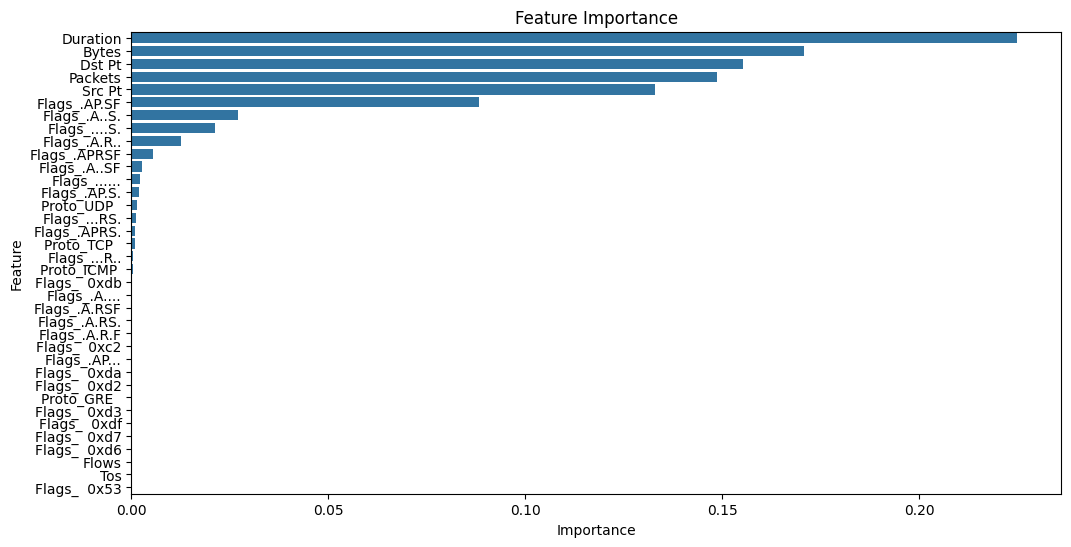

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_df['Importance'], y=feature_df['Feature'])
plt.title("Feature Importance")
plt.show()


# Evaluation

In [23]:
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Training Accuracy: 1.0000
Testing Accuracy: 0.9998


# Cross Validation

In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")


Cross-validation scores: [0.99985536 0.99978303 0.9993491  0.99960223 0.99963839]
Mean Accuracy: 0.9996


#  Due overfitting we chosing LSTM model and re-training the data

In [42]:
print("X_train shape:", X_train.shape)  # Should be (samples, timesteps, features)
print("X_test shape:", X_test.shape)    # Should be (samples, timesteps, features)

print("y_train shape:", y_train.shape)  # Should be (samples,)
print("y_test shape:", y_test.shape)    # Should be (samples,)


X_train shape: (138270, 36)
X_test shape: (34568, 36)
y_train shape: (138270, 3)
y_test shape: (34568, 3)


In [43]:
# Reshape X_train and X_test for LSTM
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, timesteps=1, features)
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_seq shape:", X_train_seq.shape)  # Should be (samples, 1, 36)
print("X_test_seq shape:", X_test_seq.shape)    # Should be (samples, 1, 36)


AttributeError: 'DataFrame' object has no attribute 'reshape'

In [44]:
import numpy as np

# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Reshape for LSTM input
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, timesteps=1, features)
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_seq shape:", X_train_seq.shape)  # Should be (138270, 1, 36)
print("X_test_seq shape:", X_test_seq.shape)    # Should be (34568, 1, 36)


X_train_seq shape: (138270, 1, 36)
X_test_seq shape: (34568, 1, 36)


In [45]:
# Convert y_train and y_test to NumPy arrays (if they aren't already)
y_train_cat = np.array(y_train)
y_test_cat = np.array(y_test)

print("y_train_cat shape:", y_train_cat.shape)  # Should be (138270, 3)
print("y_test_cat shape:", y_test_cat.shape)    # Should be (34568, 3)



y_train_cat shape: (138270, 3)
y_test_cat shape: (34568, 3)


# Model Architecture of LSTM Model

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(1, 36)),  # LSTM with 64 units
    Dense(32, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Dropout for regularization
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 64)                  │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,035 (109.51 KB)

 Trainable params: 28,035 (109.51 KB)

 Non-trainable params: 0 (0.00 B)

# Fitting data using LSTM Model

In [47]:
# Train the LSTM model
history = model.fit(X_train_seq, y_train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_seq, y_test_cat))



Epoch 1/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.8476 - loss: 0.4564 - val_accuracy: 0.8830 - val_loss: 0.3426
Epoch 2/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8730 - loss: 0.3705 - val_accuracy: 0.8765 - val_loss: 0.3257
Epoch 3/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8804 - loss: 0.3442 - val_accuracy: 0.8911 - val_loss: 0.3533
Epoch 4/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8844 - loss: 0.3333 - val_accuracy: 0.8918 - val_loss: 0.2842
Epoch 5/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.8840 - loss: 0.3174 - val_accuracy: 0.8911 - val_loss: 0.2933
Epoch 6/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8852 - loss: 0.3520 - val_accuracy: 0.8800 - val_loss: 0.3511
Epoch 7/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8833 - loss: 0.3420 - val_accuracy: 0.8922 - val_loss: 0.2890
Epoch 8/10
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8916 - loss: 0

# Evaluation

In [48]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8958 - loss: 0.2928
Test Accuracy: 0.8946, Test Loss: 0.2958


# Plotting Loss and Accuracy Curves

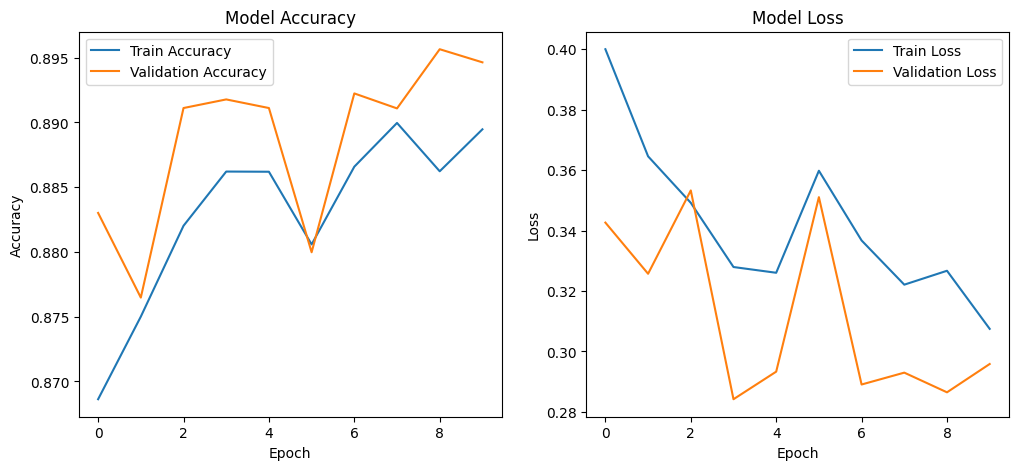

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


# Fitting For Longer Epochs

In [50]:
# Train the LSTM model
history = model.fit(X_train_seq, y_train_cat,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test_seq, y_test_cat))



Epoch 1/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.8876 - loss: 0.3216 - val_accuracy: 0.8954 - val_loss: 0.2573
Epoch 2/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8906 - loss: 0.2971 - val_accuracy: 0.8964 - val_loss: 0.2619
Epoch 3/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8925 - loss: 0.2926 - val_accuracy: 0.8942 - val_loss: 0.2759
Epoch 4/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8899 - loss: 0.2908 - val_accuracy: 0.8937 - val_loss: 0.3016
Epoch 5/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8886 - loss: 0.3080 - val_accuracy: 0.8923 - val_loss: 0.3054
Epoch 6/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8894 - loss: 0.3076 - val_accuracy: 0.9012 - val_loss: 0.2536
Epoch 7/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8945 - loss: 0.2833 - val_accuracy: 0.8879 - val_loss: 0.2820
Epoch 8/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8926 - loss: 0

# Evaluation

In [51]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8973 - loss: 0.2458
Test Accuracy: 0.8957, Test Loss: 0.2506


# Plotting Loss and Accuracy Curves

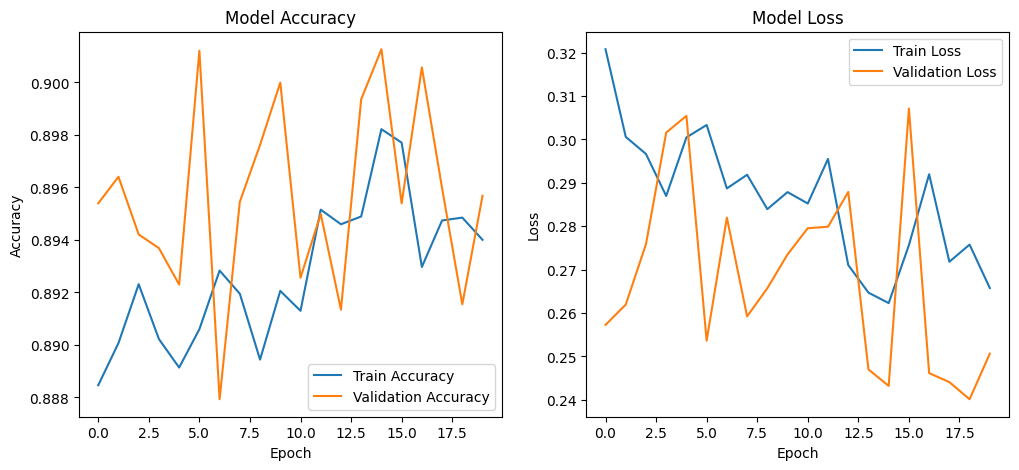

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


# EarlyStopping Callback 

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Fittinig data with EarlyStopping callback

In [55]:
history = model.fit(
    X_train_seq, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_cat),
    callbacks=[early_stopping]  # Include EarlyStopping callback
)


Epoch 1/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.8968 - loss: 0.2590 - val_accuracy: 0.8914 - val_loss: 0.2456
Epoch 2/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8968 - loss: 0.2586 - val_accuracy: 0.8983 - val_loss: 0.2611
Epoch 3/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8949 - loss: 0.2707 - val_accuracy: 0.9018 - val_loss: 0.2315
Epoch 4/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8970 - loss: 0.2546 - val_accuracy: 0.8959 - val_loss: 0.2572
Epoch 5/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8992 - loss: 0.2568 - val_accuracy: 0.8951 - val_loss: 0.2437
Epoch 6/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8968 - loss: 0.2524 - val_accuracy: 0.9031 - val_loss: 0.2385
Epoch 7/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8978 - loss: 0.2596 - val_accuracy: 0.8865 - val_loss: 0.2080
Epoch 8/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9009 - loss: 0

# Evaluation

In [56]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9045 - loss: 0.2021
Test Accuracy: 0.9035, Test Loss: 0.2059


# Plotting Loss and Accuracy Curves

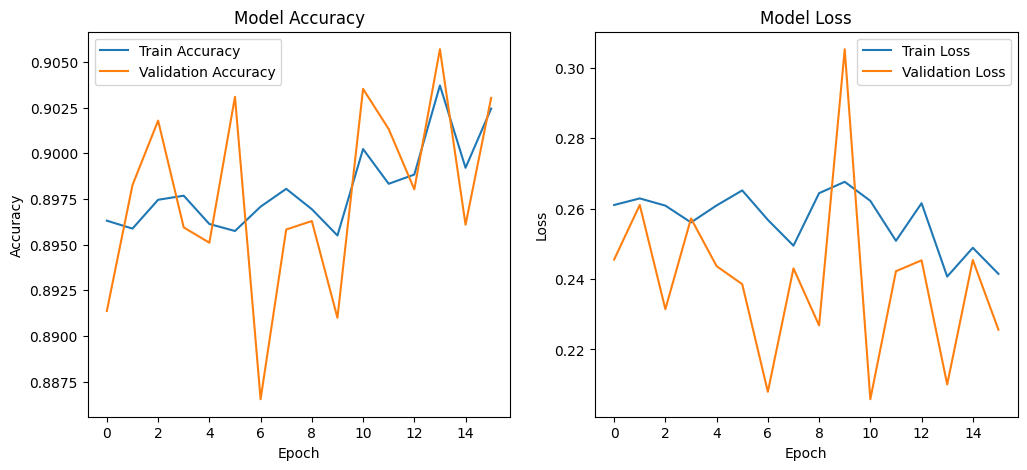

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


Now we got ~89% accuracy. To improve that we are changing the model Architecture 
# Model Architecture of LSTM(Modified), Training, Fitting

In [58]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define LSTM model with multiple LSTM layers and adjusted parameters
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, 36), kernel_regularizer=l2(0.01)),  # Increased units and added L2 regularization
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),  # Stacked LSTM with L2 regularization
    Dense(64, activation='relu'),  # Increased units in Dense layer
    Dropout(0.4),  # Increased Dropout rate
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

# Compile model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Training the model
history = model.fit(
    X_train_seq, y_train_cat,
    epochs=50,  # Increased number of epochs
    batch_size=32,
    validation_data=(X_test_seq, y_test_cat),
    callbacks=[early_stopping, model_checkpoint]  # Added ModelCheckpoint
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 1, 128)              │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,243 (540.01 KB)

 Trainable params: 138,243 (540.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4314/4321 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8169 - loss: 1.2291

4321/4321 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.8170 - loss: 1.2280 - val_accuracy: 0.9045 - val_loss: 0.2958
Epoch 2/50
4318/4321 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9071 - loss: 0.2933

4321/4321 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.9071 - loss: 0.2933 - val_accuracy: 0.9352 - val_loss: 0.2233
Epoch 3/50
4320/4321 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9186 - loss: 0.2525

4321/4321 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9186 - loss: 0.2525 - val_accuracy: 0.9281 - val_loss: 0.2174
Epoch 4/50
4316/4321 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9217 - loss: 0.2304

4321/4321 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.9217 - loss: 0.2304 - val_accuracy: 0.9356 - val_loss: 0.2054
Epoch 5/50
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9259 - loss: 0.2266 - val_accuracy: 0.9320 - val_loss: 0.2075
Epoch 6/50
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9189 - loss: 0.2338 - val_accuracy: 0.9254 - val_loss: 0.2177
Epoch 7/50
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9202 - loss: 0.2309 - val_accuracy: 0.9296 - val_loss: 0.2351
Epoch 8/50
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9169 - loss: 0.2293 - val_accuracy: 0.9267 - val_loss: 0.2065
Epoch 9/50
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9184 - loss: 0.2293 - val_accuracy: 0.8994 - val_loss: 0.2212


# Evaluation

In [59]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9367 - loss: 0.2014
Test Accuracy: 0.9356, Test Loss: 0.2054


# Making Predictions

In [61]:
# Reshape the test data to match the expected input shape of (batch_size, 1, 36)
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Now, predict using the reshaped data
predictions = model.predict(X_test_reshaped)


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


In [62]:
# Check the first few predictions
print(predictions[:10])  # Print first 10 predictions

# If it's a multi-class classification, you might want to check the class labels
predicted_classes = predictions.argmax(axis=1)  # Get the class with the highest probability
print(predicted_classes[:10])  # Print the first 10 predicted class labels


[[2.7958333e-04 9.9444675e-01 5.2736951e-03]
 [1.6418318e-04 9.9145293e-01 8.3828419e-03]
 [1.7793523e-04 9.9545979e-01 4.3622772e-03]
 [4.3549153e-04 9.9436957e-01 5.1949881e-03]
 [2.5813601e-03 5.3632396e-01 4.6109465e-01]
 [9.5765829e-01 4.2116527e-02 2.2507986e-04]
 [9.5734090e-01 4.2428464e-02 2.3063389e-04]
 [2.5813601e-03 5.3632396e-01 4.6109465e-01]
 [9.4749981e-01 5.1793981e-02 7.0612633e-04]
 [3.1374723e-03 9.7309560e-01 2.3766996e-02]]
[1 1 1 1 1 0 0 1 0 1]


In [72]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [73]:
# Predict on the test set
predictions = model.predict(X_test_seq)

# Convert predicted probabilities to class labels (argmax for multi-class classification)
predicted_classes = np.argmax(predictions, axis=1)

# Convert the true labels to class labels if they are one-hot encoded
true_classes = np.argmax(y_test_cat, axis=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy:.4f}")


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Accuracy: 0.9356


# Saving Model


In [74]:
# Save the model to a file
model.save('my_trained_final_model.h5')
print("Model saved to 'my_trained_final_model.h5'")


Model saved to 'my_trained_final_model.h5'


# Loading Model

In [75]:
from tensorflow.keras.models import load_model

# Reload the saved model
loaded_model = load_model('my_trained_final_model.h5')
print("Model loaded successfully")


Model loaded successfully


In [76]:
predictions = loaded_model.predict(X_test_seq)
predicted_classes = np.argmax(predictions, axis=1)
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy with reloaded model: {accuracy:.4f}")

1081/1081 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Accuracy with reloaded model: 0.9356
